In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1hz0dj5TVr0fFPI-mqQf7-s3JkiqQYmrx/view?usp=drivesdk'

import pandas as pd

# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('filtered_data_frame.csv')

data = pd.read_csv('filtered_data_frame.csv')
print(data)

        year  month  day  hour  minute  second  AN311  AN422  AN423  TP1721  \
0       2014      3   29    13      44      57    3.6    1.6    1.4    24.5   
1       2014      3   29    13      44      58    3.6    1.6    1.4    24.5   
2       2014      3   29    13      44      59    3.8    1.6    1.4    24.5   
3       2014      3   29    13      45       0    3.8    1.6    1.4    24.5   
4       2014      3   29    13      45       1    3.9    1.6    1.5    24.5   
...      ...    ...  ...   ...     ...     ...    ...    ...    ...     ...   
858655  2014      4    8    13      15      52    3.3    1.5    1.2    24.8   
858656  2014      4    8    13      15      53    3.3    1.5    1.2    24.8   
858657  2014      4    8    13      15      54    3.3    1.5    1.2    24.8   
858658  2014      4    8    13      15      55    3.3    1.5    1.2    24.8   
858659  2014      4    8    13      15      56    3.3    1.5    1.2    24.8   

        ...  P_864  TC862  WM868  AMP1_IR  AMP2_IR 

Text(0.5, 1.0, 'Исходные измерения')

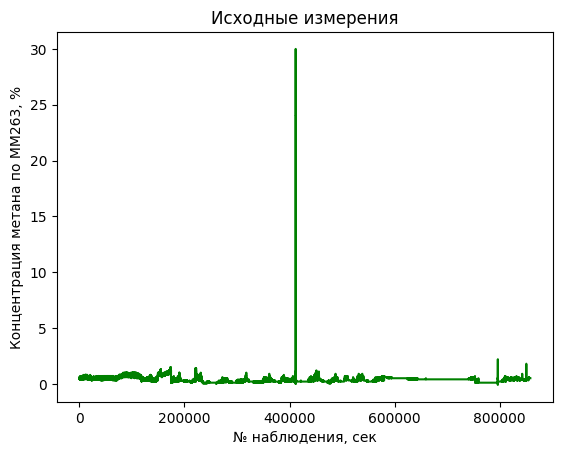

In [ ]:
from matplotlib import pyplot as plt

plt.plot(range(len(data)), data['MM263'], color = '#008000')
plt.xlabel('№ наблюдения, сек')
plt.ylabel('Концентрация метана по MM263, %')
plt.title('Исходные измерения')

In [ ]:
data = data[data >= 0].dropna()

In [ ]:
data = data.drop(data[(data['MM263'] > 1.4)].index)

Text(0.5, 1.0, 'Очищенные от выбросов измерения')

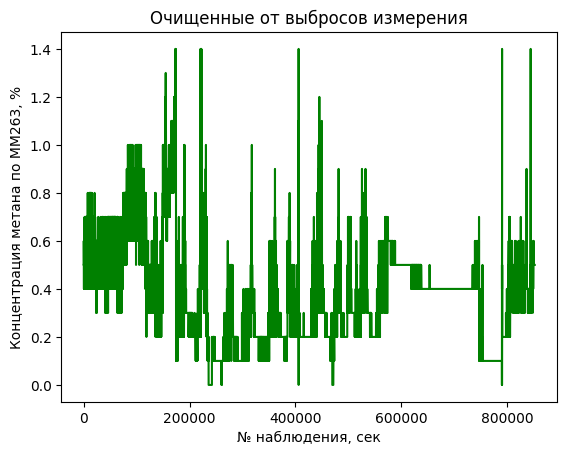

In [ ]:
plt.plot(range(len(data)), data['MM263'], color = '#008000')
plt.xlabel('№ наблюдения, сек')
plt.ylabel('Концентрация метана по MM263, %')
plt.title('Очищенные от выбросов измерения')

Text(0.5, 1.0, 'Очищенные от выбросов измерения')

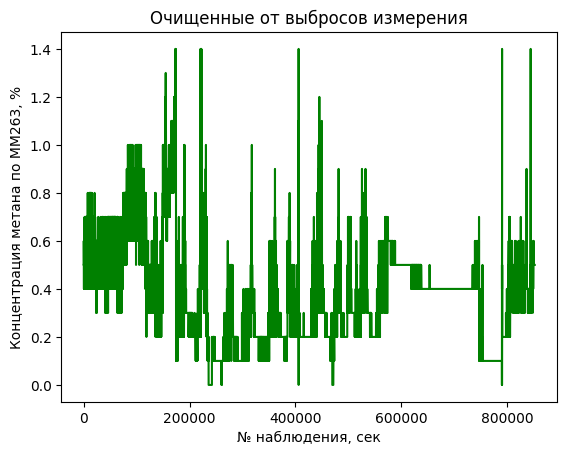

In [ ]:
plt.plot(range(len(data)), data['MM263'], color = '#008000')
plt.xlabel('№ наблюдения, сек')
plt.ylabel('Концентрация метана по MM263, %')
plt.title('Очищенные от выбросов измерения')

In [ ]:
data_filtered = data.apply(lambda x: x.ewm(alpha=0.1).mean(), axis=0)

data_filtered = data_filtered.apply(lambda x: x.ewm(alpha=0.01).mean(), axis=0)

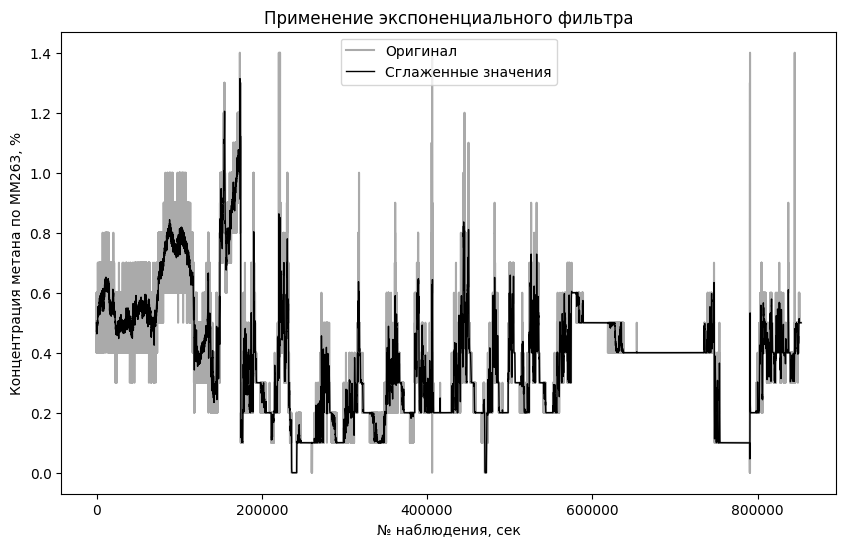

In [ ]:
data_size = len(data)

plt.figure(figsize=(10, 6))
plt.plot(range(data_size), data['MM263'], color='#aaa', label='Оригинал')
plt.plot(range(data_size), data_filtered['MM263'], linewidth=1, color='black', label='Сглаженные значения')
plt.xlabel('№ наблюдения, сек')
plt.ylabel('Концентрация метана по MM263, %')
plt.legend()
plt.title('Применение экспоненциального фильтра')

plt.show()

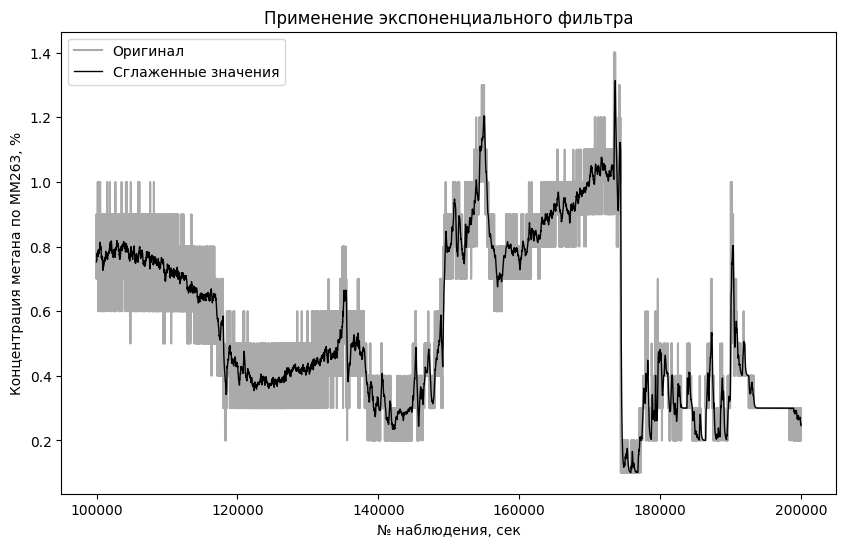

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(100000,200000), data['MM263'][100000:200000], color='#aaa', label='Оригинал')
plt.plot(range(100000,200000), data_filtered['MM263'][100000:200000], linewidth=1, color='black', label='Сглаженные значения')
plt.xlabel('№ наблюдения, сек')
plt.ylabel('Концентрация метана по MM263, %')
plt.legend()
plt.title('Применение экспоненциального фильтра')

plt.show()

In [ ]:
data = data_filtered.copy()

In [ ]:
data.drop(['year', 'month', 'day', 'hour', 'minute', 'second'], axis=1, inplace=True)

In [ ]:
interval = 15 * 60 #сдвигаем данные на 15 минут, чтобы модель могла
data['y'] = data['MM263'].shift(-interval) #сделать прогноз через 15 минут
data.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

#делим датасет на 2 чати: для обучения (70%) и для теста (30%) и перемешиваем данные
X = data.drop(columns='y')
y = data[['y']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#используем MinMax нормализацию и выполняем её
scaler = MinMaxScaler()
X_columns = X_train.columns
y_columns = y_train.columns

X_train[X_columns] = scaler.fit_transform(X_train[X_columns])
X_test[X_columns] = scaler.transform(X_test[X_columns])

y_train[y_columns] = scaler.fit_transform(y_train[y_columns])
y_test[y_columns] = scaler.transform(y_test[y_columns])

In [ ]:
import torch
from torch.utils.data import Dataset

In [ ]:
import pandas as pd
import numpy as np

#Класс для итерирования строк датасета, нужен для нейронной сети
class MethaneDataset(Dataset):
#конструктор
    def __init__(self, data, transform=None, target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform
#функция, которая выдает длину таблицы (кол-во строк)
    def __len__(self):
        return self.data.shape[0]
#функция, которая позволяет получить конкретную строку по её номеру
    def __getitem__(self, idx):
        factors = self.data.iloc[idx, :-1].values.astype(np.float32)
        y = self.data.iloc[idx, -1].reshape(-1).astype(np.float32)
        if self.transform:
            factors = self.transform(factors)
        if self.target_transform:
            y = self.target_transform(y)
        return factors, y #выдаем для нейросети x и y

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1) #объединяем x и y в одну таблицу
test_data = pd.concat([X_test, y_test], axis=1)

In [ ]:
train = MethaneDataset(
    train_data,
    transform=torch.tensor,
)

test = MethaneDataset(
    test_data,
    transform=torch.tensor,
)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test, batch_size=64, shuffle=False)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer): #обучение модели на всем датасете
    num_batches = len(dataloader)
    current = 0
    train_loss = 0
    train_mae = 0

    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y) #подсчет средней квадратичной ошибка (loss)
        mae = torch.mean(torch.abs(pred - y)) # подсчет средней абсолютной ошибки (MAE)

        #настройка параметров нейросети
        optimizer.zero_grad()
        loss.backward() # обратный проход
        optimizer.step()

        loss = loss.item()
        current += len(X)
        train_loss += loss
        train_mae += mae.item()

    train_loss /= num_batches
    train_mae /= num_batches # подсчет средних значений за эпоху
    print(f"\nПоказатели обучения: Средняя квадратичная ошибка (Average loss): {train_loss:>8f}, Средняя абсолютная ошибка (Average MAE): {train_mae:>8f} \n")
    return train_loss, train_mae #получаем итоговые ошибки за эпоху


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss = 0
    test_mae = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss = loss_fn(pred, y)
            mae = torch.mean(torch.abs(pred - y))

            test_loss += loss.item()
            test_mae += mae.item()

            all_preds.append(pred)
            all_targets.append(y)

    test_loss /= num_batches
    test_mae /= num_batches
    print(f"Показатели тестирования: Средняя квадратичная ошибка (Average loss): {test_loss:>8f}, Средняя абсолютная ошибка (Average MAE): {test_mae:>8f} \n")

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return test_loss, test_mae, all_preds, all_targets #получаем итоговые ошибки за эпоху, а также предсказания и истинные значения через 15 минут


In [ ]:
def get_results(model, num_epochs, loss_fn, optimizer):
    for t in range(num_epochs):
        print(f"Эпоха {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)

    print("Нейросеть обучена!")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
#Класс нейросети
class RegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

input_size = train_features.size()[1] # размер входного (input) слоя
hidden_size = 64 # размер скрытого (hidden) слоя
output_size = train_labels.size()[1] # размер выходного (output) слоя

model = RegressionNet(input_size, hidden_size, output_size)

In [ ]:
learning_rate = 1e-3 # шаг обучения
epochs = 15 # число (кол-во) эпох обучения
loss_fn = nn.MSELoss() # функция потерь (функция средней квадратичной ошибки)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # оптимизатор (с учётом предыдущего шага)

In [ ]:
get_results(model, epochs, loss_fn, optimizer)

Эпоха 1
-------------------------------

Показатели обучения: Средняя квадратичная ошибка (Average loss): 0.002415, Средняя абсолютная ошибка (Average MAE): 0.030237 

Показатели тестирования: Средняя квадратичная ошибка (Average loss): 0.001691, Средняя абсолютная ошибка (Average MAE): 0.025783 

Эпоха 2
-------------------------------

Показатели обучения: Средняя квадратичная ошибка (Average loss): 0.001330, Средняя абсолютная ошибка (Average MAE): 0.023232 

Показатели тестирования: Средняя квадратичная ошибка (Average loss): 0.000969, Средняя абсолютная ошибка (Average MAE): 0.019997 

Эпоха 3
-------------------------------

Показатели обучения: Средняя квадратичная ошибка (Average loss): 0.000936, Средняя абсолютная ошибка (Average MAE): 0.019609 

Показатели тестирования: Средняя квадратичная ошибка (Average loss): 0.000826, Средняя абсолютная ошибка (Average MAE): 0.018772 

Эпоха 4
-------------------------------

Показатели обучения: Средняя квадратичная ошибка (Average loss

In [ ]:
full_data = pd.concat([train_data, test_data], axis=0)
full_data.sort_index(inplace=True)

In [ ]:
full_dataset = MethaneDataset(
    full_data,
    transform=torch.tensor,
)

full_dataloader = DataLoader(full_dataset, batch_size=64, shuffle=False)

In [ ]:
test_loss, test_mae, all_preds, all_targets = test_loop(full_dataloader, model, loss_fn)

Показатели тестирования: Средняя квадратичная ошибка (Average loss): 0.000303, Средняя абсолютная ошибка (Average MAE): 0.011052 



In [ ]:
all_preds = scaler.inverse_transform(all_preds.reshape(-1, 1)).flatten() # денормирование данных
all_targets = scaler.inverse_transform(all_targets.reshape(-1, 1)).flatten()

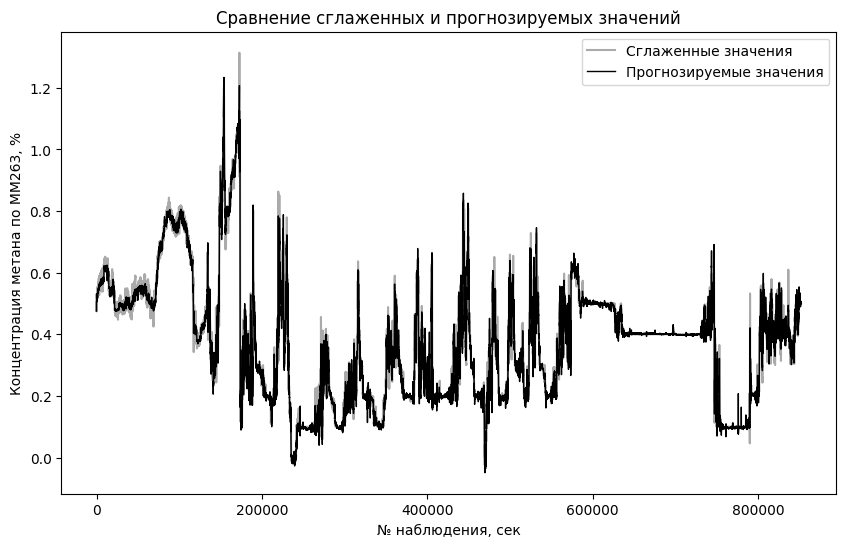

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(all_targets, label='Сглаженные значения', color='#aaa')
plt.plot(all_preds, label='Прогнозируемые значения', linewidth=1, color='black')
plt.xlabel('№ наблюдения, сек')
plt.ylabel('Концентрация метана по MM263, %')
plt.legend()
plt.title('Сравнение сглаженных и прогнозируемых значений')

plt.show()

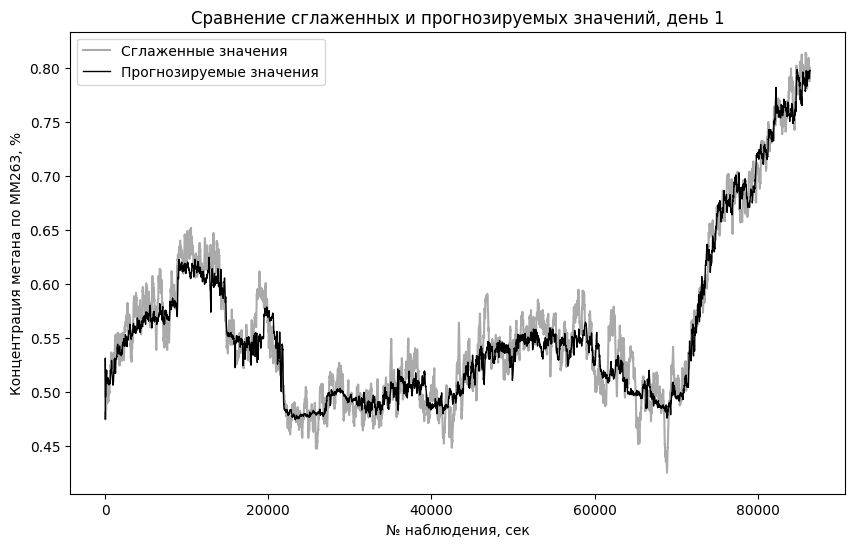

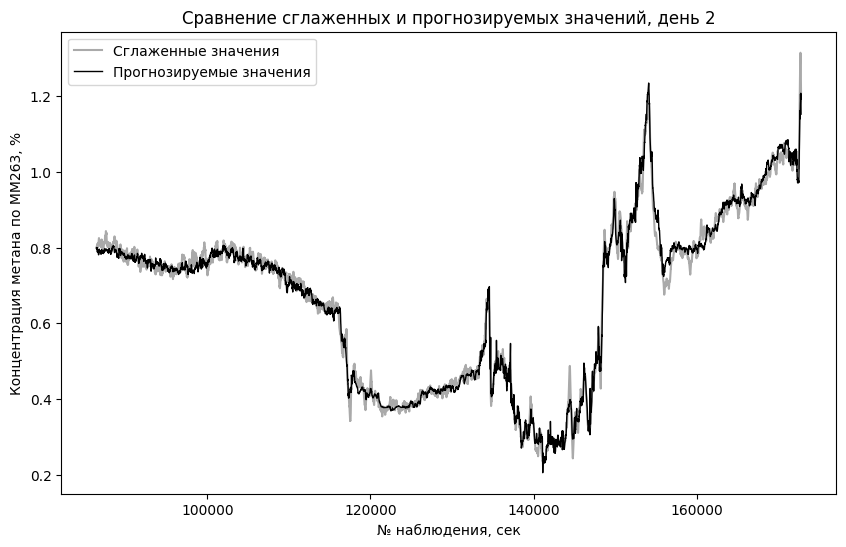

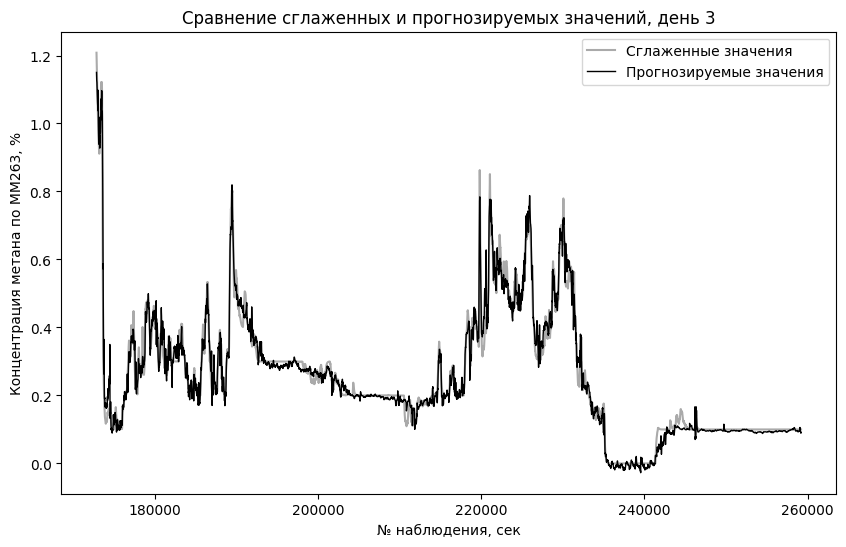

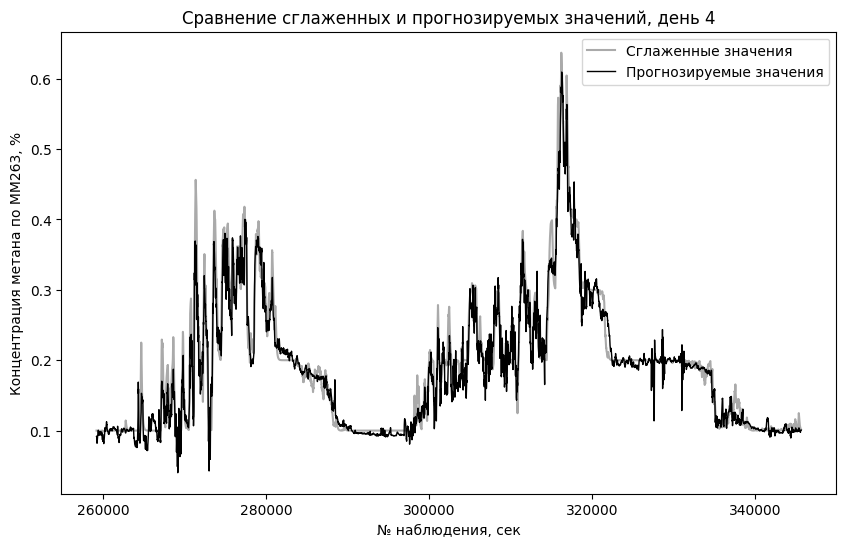

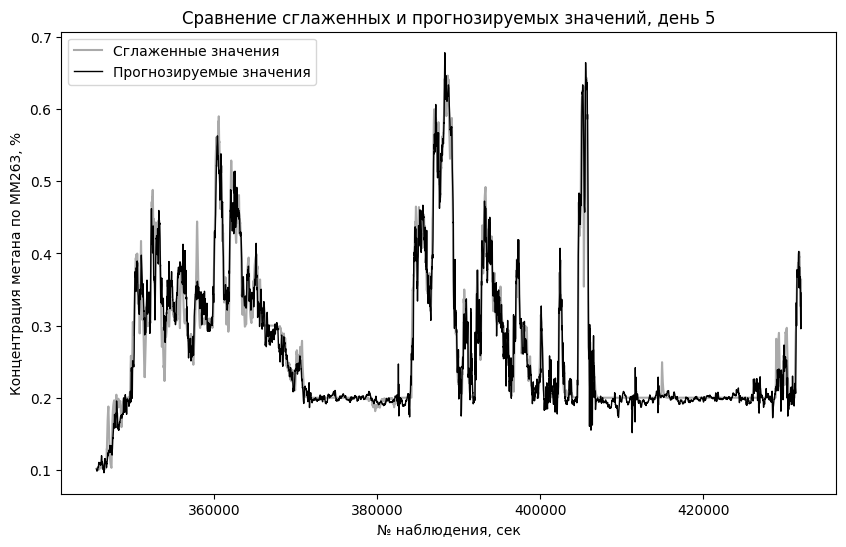

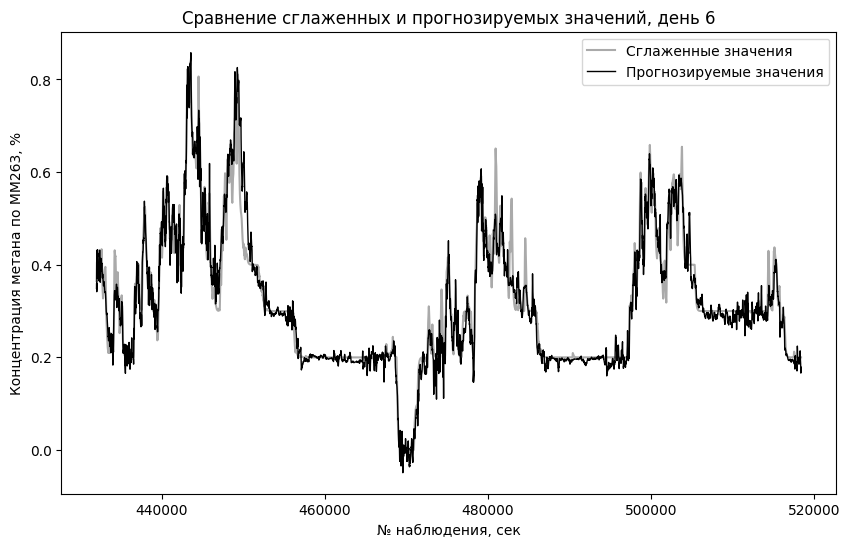

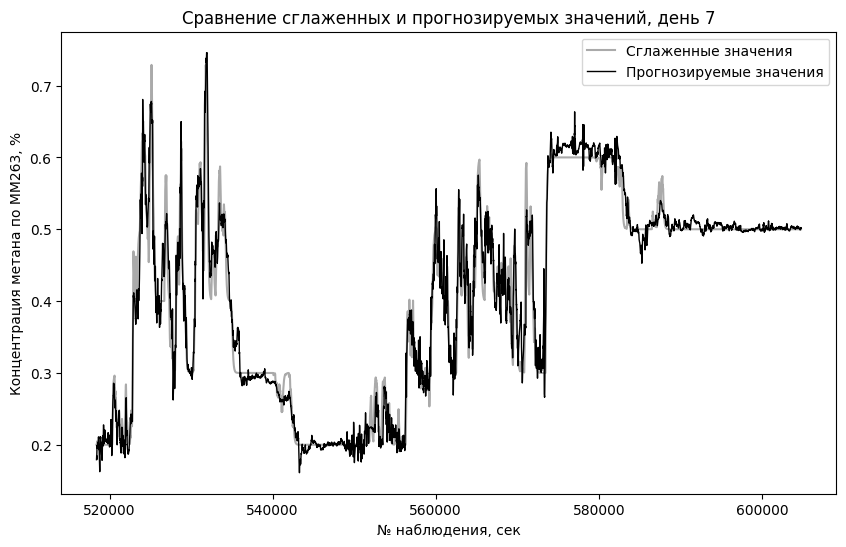

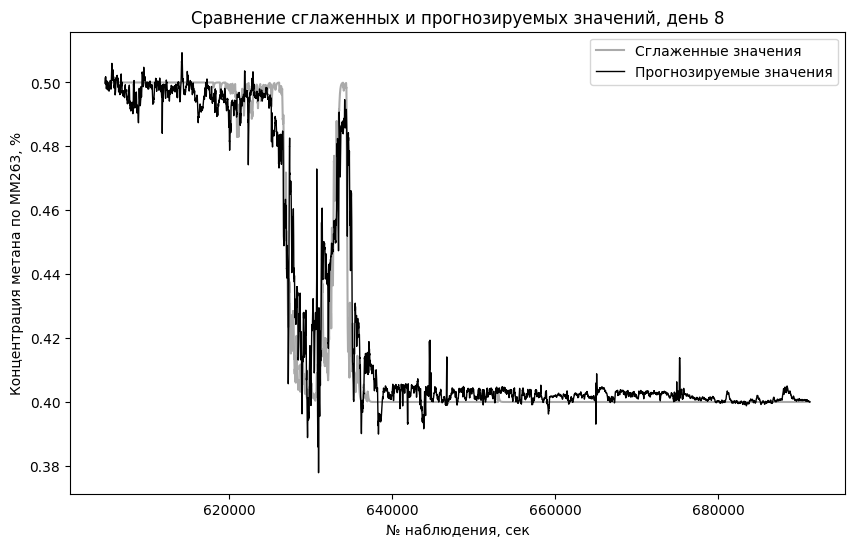

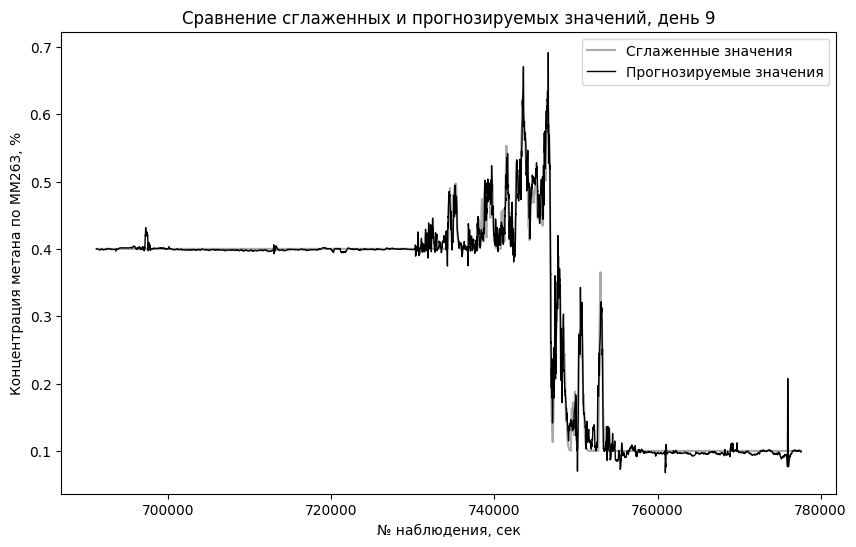

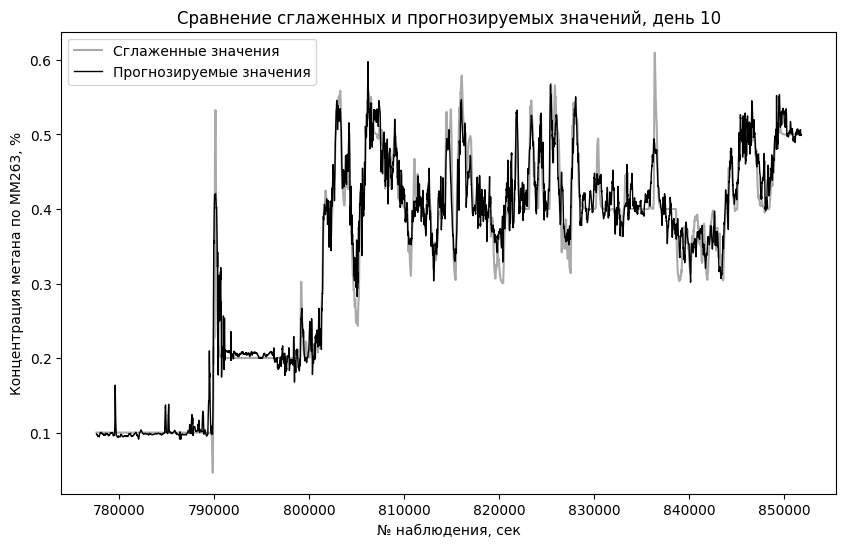

In [ ]:
part_size = 24 * 60 * 60
num_parts = 10

for i in range(num_parts):
    start_idx = i * part_size
    if i == num_parts - 1:
        end_idx = len(all_targets)
    else:
        end_idx = (i + 1) * part_size

    plt.figure(figsize=(10, 6))
    plt.plot(range(start_idx, end_idx), all_targets[start_idx:end_idx], label='Сглаженные значения', color='#aaa')
    plt.plot(range(start_idx, end_idx), all_preds[start_idx:end_idx], label='Прогнозируемые значения', linewidth=1, color='black')
    plt.xlabel('№ наблюдения, сек')
    plt.ylabel('Концентрация метана по MM263, %')
    plt.legend()
    plt.title(f'Сравнение сглаженных и прогнозируемых значений, день {i + 1}')

    plt.show()
